# Time Series Analysis on the max load each day

In [684]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import BATS, TBATS
from statsmodels.tsa.stl.mstl import MSTL

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [581]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_4.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [582]:
# Group by day and then get max value for each day
df_day = df.groupby(df.index.date).max()
df_day = df_day.rename(columns={'net_load_kWh':'max_load_kWh'})
df_day.index = pd.to_datetime(df_day.index)

### Train test split

In [583]:
y = df_day['max_load_kWh']
y_train = df_day['max_load_kWh'].iloc[:(len(y)-365)]
y_test = df_day['max_load_kWh'].iloc[(len(y)-365):] # last year for testing

## Visualize the time series

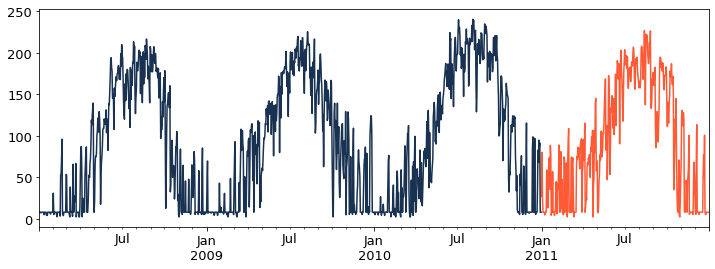

In [584]:
fig, ax = plt.subplots(figsize=[12, 4])
y_train.plot(ax=ax)
y_test.plot(ax=ax)
plt.show()

### Scaling the time series (not sure if this is needed)

In [585]:
values = y_train.values.reshape(-1,1)

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(values)
#scaler.inverse_transform(y_train_scaled)

In [586]:
y_train_scaled = pd.DataFrame(y_train_scaled, columns=['max_load_kWh'])
y_train_scaled.index = y_train.index

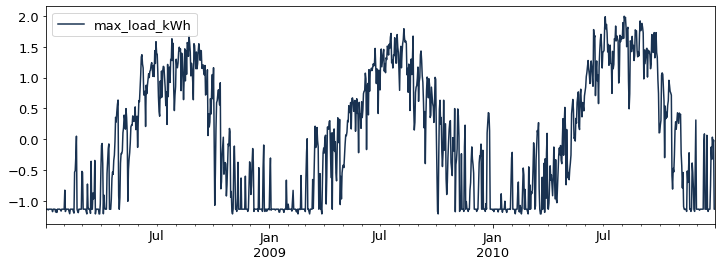

In [587]:
fig, ax = plt.subplots(figsize=[12, 4])
y_train_scaled.plot(ax=ax)
plt.show()

## Baseline model 

We assume for the baseline model, this year's load is exactly the same as last year's.

In [588]:
# Split data into train and test set
y_train = df_day['max_load_kWh'][:365*3]
y_test = df_day['max_load_kWh'][365*3:]

In [589]:
y_pred = y_train[-365:]
y_pred.index = y_test.index

In [590]:
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred).round(3)}")

Mean Absolute Error = 35.585
Mean Squared Error = 2134.251


### Helper functions

In [591]:
def plot_decomposition(seas_decomp_yearly):
    
    cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
    sns.set_palette(palette=cmaps_hex)
    sns_c = sns.color_palette(palette=cmaps_hex)

    # Plots:
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

    #Plot Signal
    ax[0].set(title='Observed data (signal)', 
            ylabel='kWh')
    seas_decomp_yearly.observed.plot(color=sns_c[0], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[0])
    #Plot Trend
    ax[1].set(title='Trend (364 days moving average)', 
            ylabel='kWh')
    seas_decomp_yearly.trend.plot(color=sns_c[1], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[1])
    #Plot Seasonality
    ax[2].set(title='Seasonality', 
            ylabel='kWh')
    seas_decomp_yearly.seasonal.plot(
                                    color=sns_c[2], 
                                    linewidth=1,
                                    sharex=True,
                                    ax=ax[2])
    #Plot residual
    ax[3].set(title='Residual', 
            ylabel='kWh');
    ax[3].scatter(
        x=seas_decomp_yearly.resid.index,
        y=seas_decomp_yearly.resid,
        color=sns_c[3],
        s=4)

def stationarity_test(stock_close_price):
    
#     # Calculate rolling mean and rolling standard deviation
#     rolling_mean = stock_close_price.rolling(rolling).mean()
#     rolling_std_dev = stock_close_price.rolling(rolling).std()
    
#     # Plot the statistics
#     plt.figure(figsize=(24,6))
#     #plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
#     plt.plot(stock_close_price, color='#99D04A',label='Original Time Series')
#     plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
#     plt.xticks([])
#     plt.legend(loc='best')
#     plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    if adf_test[1] < 0.05:
        print("Time series is stationary")
    else:
        print("Time series is not stationary")
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    if kpss_test[1] < 0.05:
        print("Time series is not stationary")
    else:
        print("Time series is stationary")
    print('----'*10)

def plot_ts(ts = None, ts_add = None, title ='Time Series', legend=['1']):
    """
    Plots one or two time series in a single plot
    
        Args:
        ts: 1d- or 2d-array of time series. Dimension
            must be (n,) or (n,2)
        title: Title for the time plot.
        legend: list of legend names. If empty no legend.
        
        Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(10, 4))
    plt.plot(ts[:,], color="orange")
    plt.grid(True,axis='y')
    plt.title(title)
    if ts_add is not None:
        plt.plot(ts_add, color="blue")
    if len(legend) > 0:
        plt.legend(legend)
    plt.show()

## Holt-Winters Triple Exponential Smoothing (for data with trend and seasonality)

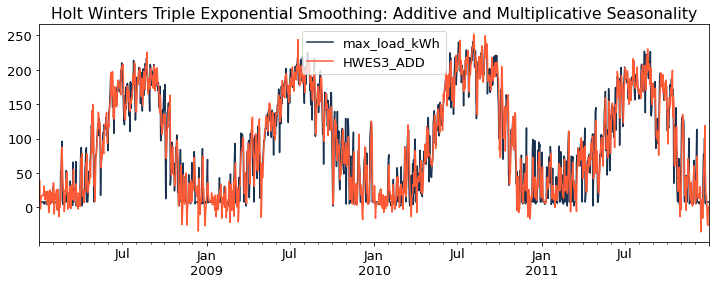

In [592]:
df_day['HWES3_ADD'] = ExponentialSmoothing(df_day['max_load_kWh'], trend='add', seasonal='add', seasonal_periods=365).fit().fittedvalues

fig, ax = plt.subplots(figsize=[12, 4])
df_day[['max_load_kWh','HWES3_ADD']].plot(ax=ax, title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality');


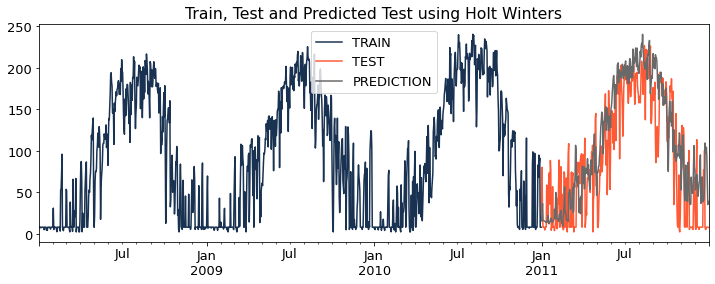

In [593]:
y_train = df_day[:365*3]
y_test = df_day[365*3:]

fitted_model = ExponentialSmoothing(y_train['max_load_kWh'],trend='add',seasonal='add',seasonal_periods=365).fit()
test_predictions = fitted_model.forecast(365)
y_train['max_load_kWh'].plot(legend=True,label='TRAIN')
y_test['max_load_kWh'].plot(legend=True,label='TEST',figsize=(12,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

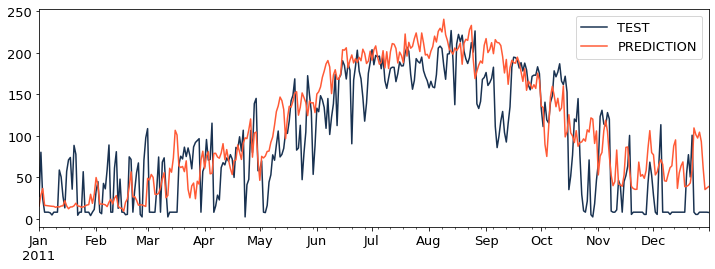

In [594]:
y_test['max_load_kWh'].plot(legend=True,label='TEST',figsize=(12,4))
test_predictions.plot(legend=True,label='PREDICTION');

In [595]:
print(f"Mean Absolute Error = {mean_absolute_error(y_test['max_load_kWh'], test_predictions).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test['max_load_kWh'], test_predictions).round(3)}")

Mean Absolute Error = 33.876
Mean Squared Error = 1824.049


## Decomposition of the time series (assuming yearly seasonality only)

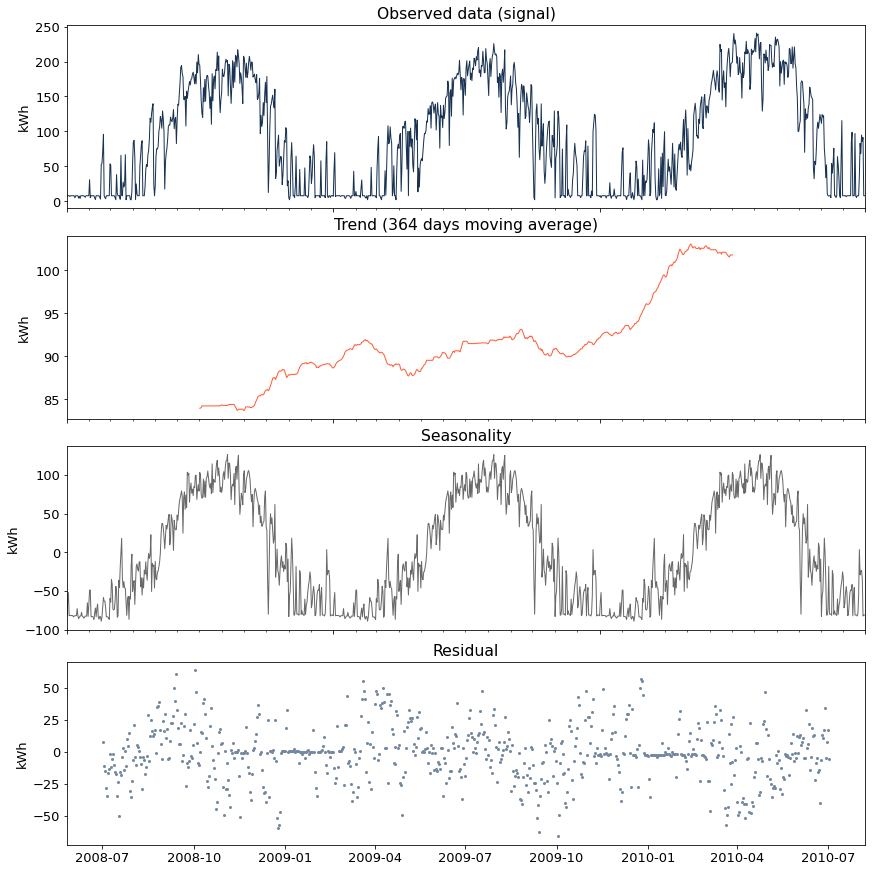

In [596]:
# Decomposition assuming only one seasonality of one year (365 days)
decomp = seasonal_decompose(y_train['max_load_kWh'], model='add', period=365)
plot_decomposition(decomp)

### Removing trend and yearly seasonality

In [639]:
df_detrend = y_train['max_load_kWh'] - decomp.trend - decomp.seasonal
df_detrend = pd.DataFrame(df_detrend.dropna(), columns=['max_load_kWh'])

### Plotting detrended time series

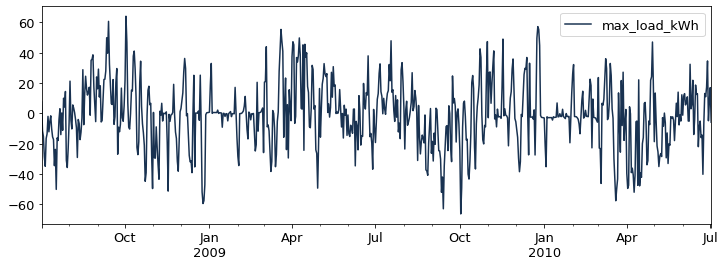

In [598]:
fig, ax = plt.subplots(figsize=[12, 4])
df_detrend.plot(ax=ax)
plt.show()

### Testing for stationarity on detrended time series

In [640]:
stationarity_test(df_detrend)

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -4.391089
p-value: 0.000308
Time series is stationary
----------------------------------------
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.139194
p-value: 0.100000
Time series is stationary
----------------------------------------


### Examining if there is weekly seasonality

In [599]:
df_detrend_week = df_detrend.copy()
df_day_week = df_day.copy()
df_detrend_week['day_name'] = df_detrend_week.index.day_name()
df_day_week['day_name'] = df_day.index.day_name()

<AxesSubplot:xlabel='day_name'>

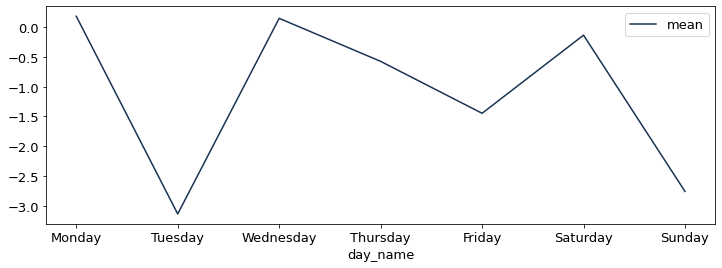

In [641]:
df_plot = df_detrend_week.groupby('day_name')['max_load_kWh'].agg(['mean'])
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekday = df_plot.groupby(['day_name']).sum().reindex(cats) 
fig, ax = plt.subplots(figsize=(12,4))
df_weekday.plot(ax=ax)


<AxesSubplot:xlabel='day_name'>

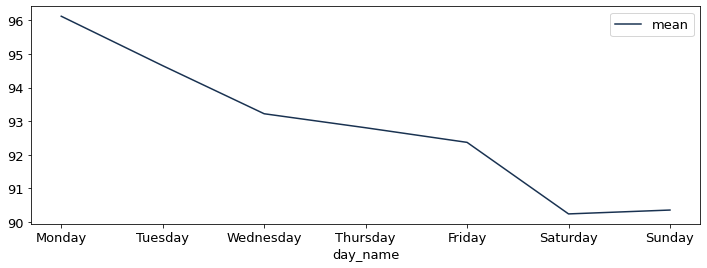

In [642]:
df_plot = df_day_week.groupby('day_name')['max_load_kWh'].agg(['mean'])
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekday = df_plot.groupby(['day_name']).sum().reindex(cats) 
fig, ax = plt.subplots(figsize=(12,4))
df_weekday.plot(ax=ax)


<AxesSubplot:xlabel='day_name'>

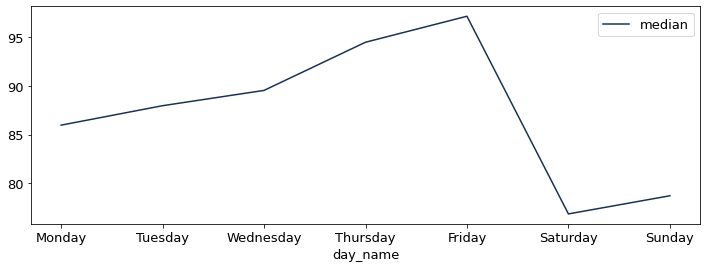

In [602]:
df_plot = df_day_week.groupby('day_name')['max_load_kWh'].agg(['median'])
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_weekday = df_plot.groupby(['day_name']).sum().reindex(cats) 
fig, ax = plt.subplots(figsize=(12,4))
df_weekday.plot(ax=ax)


## ACF and PACF plots

### Plotting ACF and PACF for data with max load for each day

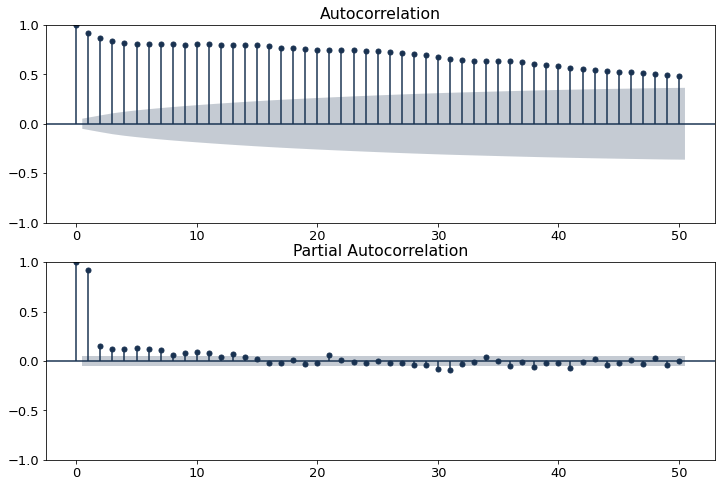

In [626]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df_day['max_load_kWh'], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_day['max_load_kWh'], lags=50, ax=ax[1])
plt.show()


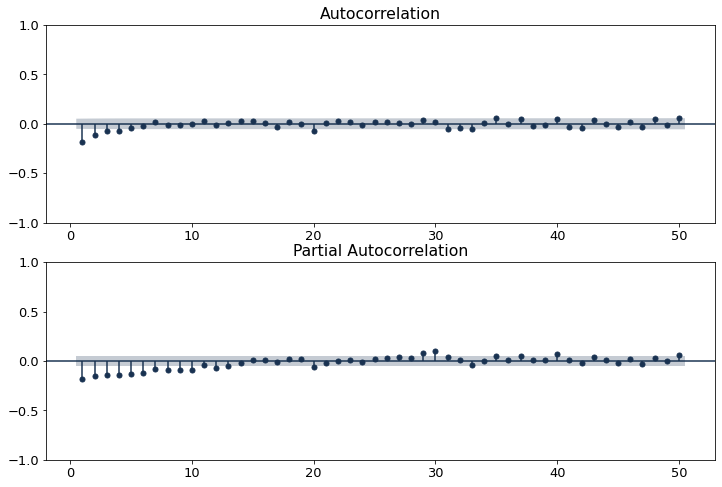

In [635]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df_day['max_load_kWh'].diff().dropna(), lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_day['max_load_kWh'].diff().dropna(), lags=50, zero=False, ax=ax[1])
plt.show()


This looks like a AR(10) model and MA(4) model 

### Plotting ACF and PACF for detrended data

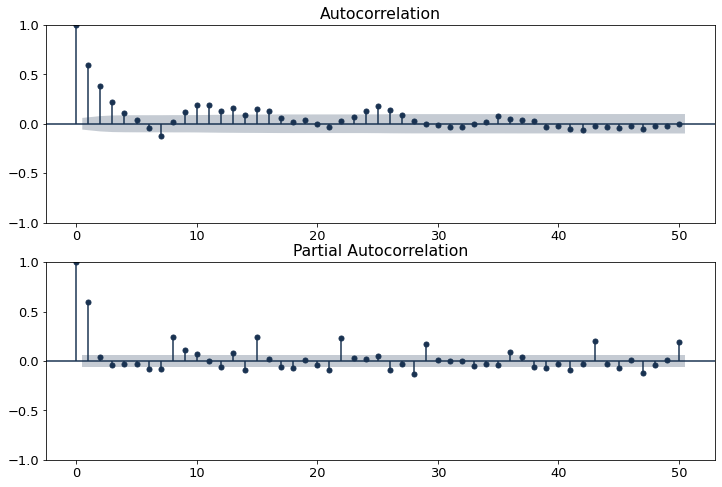

In [636]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df_detrend, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_detrend, lags=50, ax=ax[1])
plt.show()


This looks like a AR(1) model and MA(4) model 

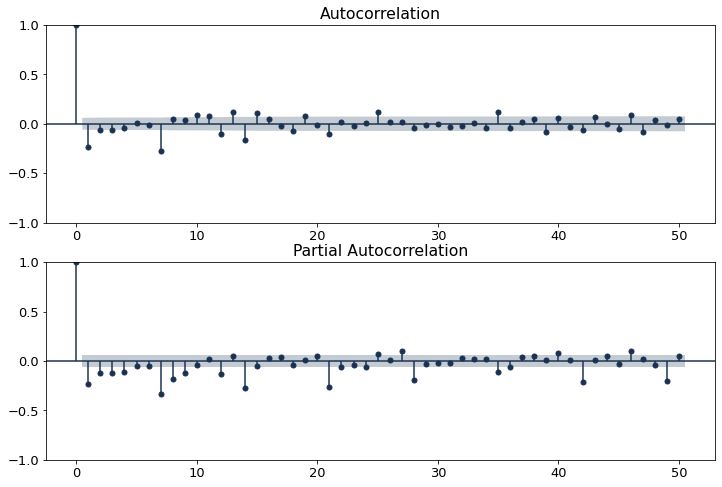

In [634]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df_detrend.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_detrend.diff().dropna(), lags=50, ax=ax[1])
plt.show()


## ARIMA model

In [677]:
model = ARIMA(df_detrend, order=(1,0,4))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           max_load_kWh   No. Observations:                  731
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -3119.553
Date:                Mon, 18 Jul 2022   AIC                           6253.107
Time:                        13:52:43   BIC                           6285.268
Sample:                    07-02-2008   HQIC                          6265.514
                         - 07-02-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1057      2.408     -0.459      0.646      -5.825       3.614
ar.L1          0.9591      0.032     29.596      0.000       0.896       1.023
ma.L1         -0.4050      0.046     -8.776      0.0

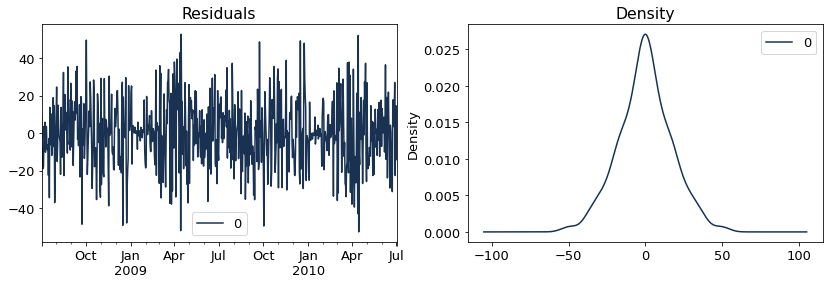

In [678]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


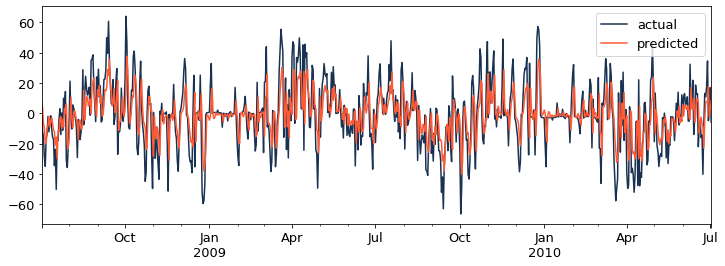

In [679]:
# Actual vs Fitted
y_pred = model_fit.predict(dynamic=False)
fig, ax = plt.subplots(figsize=(12,4))
df_detrend['max_load_kWh'].plot(ax=ax, label="actual")
y_pred.plot(ax=ax, label="predicted")
plt.legend()

### Fitting trend line

In [727]:
df_trend = pd.DataFrame()
df_trend['max_load_kWh'] = decomp.trend.dropna()
df_trend['time'] = np.arange(len(df_trend.index))

X = df_trend.loc[:, ['time']]        # features
y = df_trend.loc[:, 'max_load_kWh']  # target
linreg = LinearRegression()
linreg.fit(X,y)
df_trend['y_pred_lin'] = linreg.predict(X)

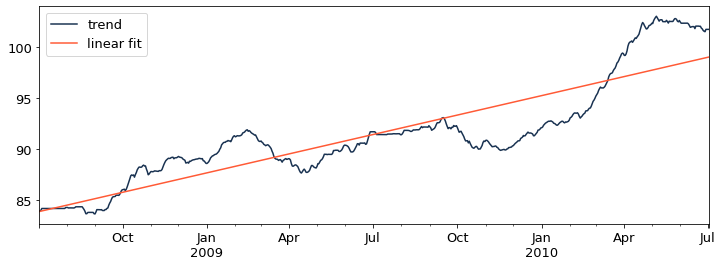

In [728]:
# Plotting trend with fitted linear regression line
fig, ax = plt.subplots(figsize=(12,4))
decomp.trend.dropna().plot(ax=ax)
df_trend['y_pred_lin'].plot(ax=ax, label="linear fit")
plt.legend()

### Fitting the yearly seasonality

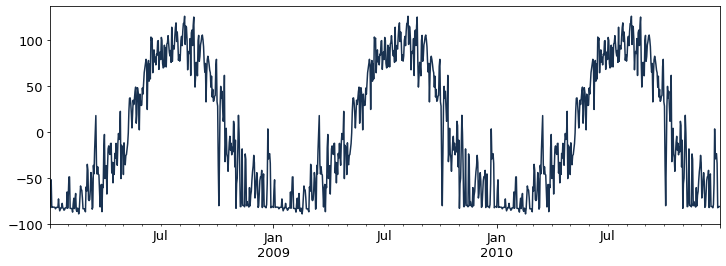

In [737]:
fig, ax = plt.subplots(figsize=(12,4))
decomp.seasonal.dropna().plot(ax=ax)

df_seasonal = pd.DataFrame()
df_seasonal['max_load_kWh'] = decomp.seasonal.dropna()

(0.0, 5.0)

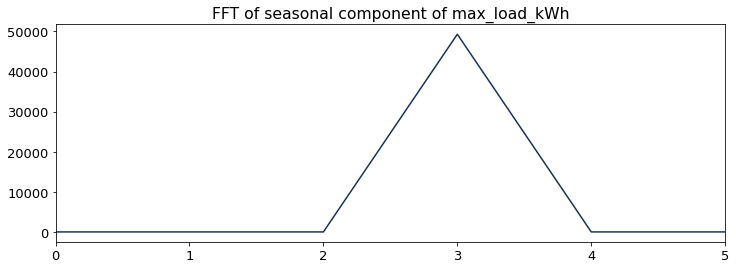

In [750]:
from scipy.fftpack import fft

fft = fft((df_seasonal.max_load_kWh - df_seasonal.max_load_kWh.mean()).values)

fig, ax = plt.subplots(figsize=(12,4))
plt.plot(np.abs(fft))
plt.title("FFT of seasonal component of max_load_kWh")
plt.xlim([0,5])
#plt.xlim([365-30, 365 + 30])



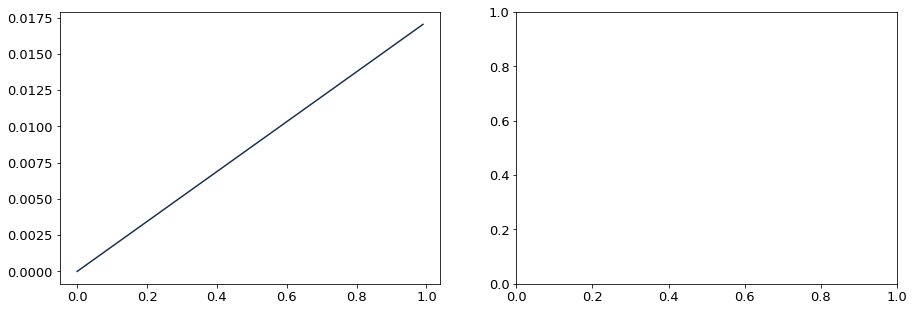

In [758]:
# Frequency and sampling rate
f = 1/365 # frequency
Fs = 100 # sampling rate
t = np.arange(0,1,1/Fs)

# Sine function
y = np.sin(2 * np.pi * f * t)

# Perform Fourier transform using scipy
from scipy import fftpack
y_fft = fftpack.fft(y)

# Plot data
n = np.size(t)
#fr = Fs/2 * np.linspace(0,1,n/2)
#y_m = 2/n * abs(y_fft[0:np.size(fr)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(t, y)    # plot time series
#ax[1].stem(fr, y_m) # plot freq domain


## Decomposition for multiple seasonalities using MSTL

In [605]:
mstl = MSTL(y_train["max_load_kWh"], periods=(7, 365), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

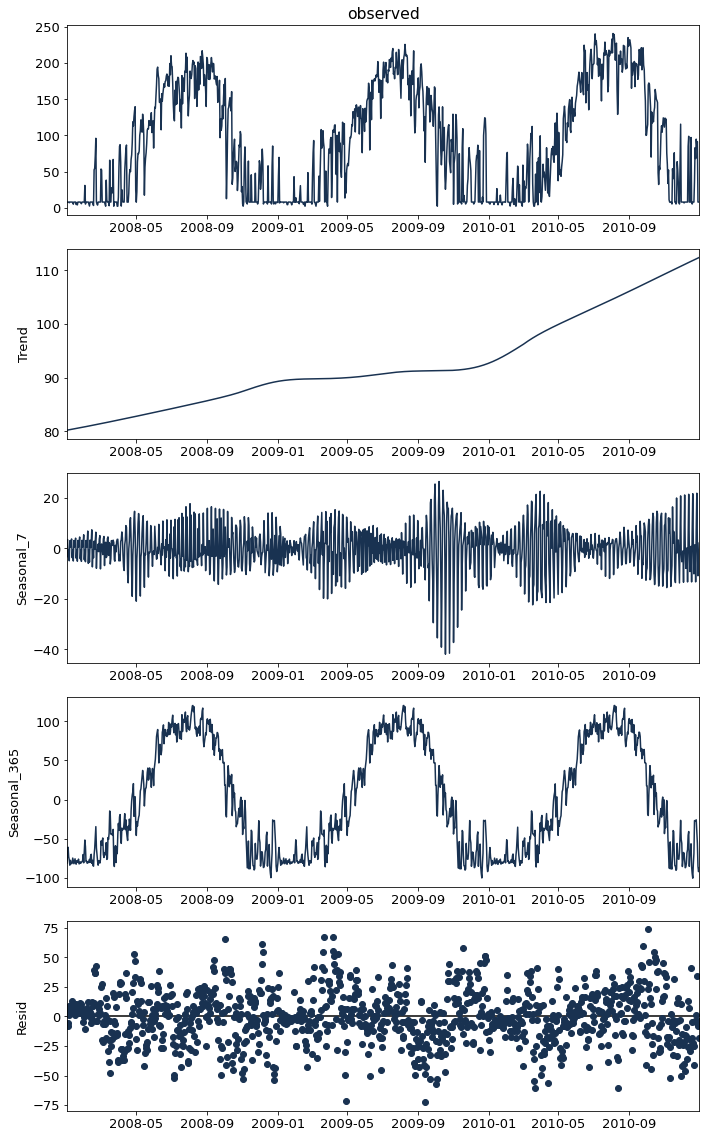

In [606]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(10, 16))
plt.rc("font", size=13)
fig = res.plot()

In [607]:
df_detrend = y_train['max_load_kWh'] - res.trend - res.seasonal.seasonal_7 - res.seasonal.seasonal_365
df_detrend = df_detrend.dropna()

In [622]:
# import pmdarima as pm

# # Seasonal - fit stepwise auto-ARIMA
# smodel = pm.auto_arima(y_train['max_load_kWh'], start_p=1, start_q=1,
#                          test='adf',
#                          max_p=3, max_q=3, m=365,
#                          start_P=0, seasonal=True,
#                          d=None, D=1, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

# smodel.summary()

In [623]:
# stepwise_model = auto_arima(df_detrend['max_load_kWh'], start_p=1, start_q=1,
#                            max_p=3, max_q=3, m=14,
#                            start_P=0, seasonal=True,
#                            d=1, D=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())